### Importing libraries

In [1]:
# Import default libraries
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import seaborn as sns
import time
import random
import warnings
import os
import requests
import json
import time
import zipfile
# Import Biopython utils
from Bio.PDB import PDBList, calc_angle, calc_dihedral, PPBuilder, is_aa, PDBIO, NeighborSearch, DSSP, HSExposureCB
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import IUPACData
from Bio.PDB.PDBIO import Select

### Helping functions

### Importing original dataset (LIP tagged sequences)

In [2]:
# Function for tagging residues as LIP/non-LIP
# Overwrites entries in the second dataset with LIP flag from the first dataset
def LIP_tag(ds_original, ds_residues):
    #For every protein we take the information of where LIP residue are
    for idx, row in ds_original.iterrows():
        # Bind information to correct variables
        pdb, chain, start, end = (row[0:4])
        # Skips if start and and are 'neg'
        if (start == 'neg') or (end == 'neg'):
            continue
        # Cast start and end values to integer
        start, end = int(start), int(end)
        # Get the correct slice of data which will be edited
        sliced = ((ds_residues['PDB_ID'] == pdb) 
                    & (ds_residues['CHAIN_ID'] == chain) 
                    & (ds_residues['RES_ID'] <= end) 
                    & (ds_residues['RES_ID'] >= start))
        #Now we set to 1 all the residue whose features are the one desired 
        ds_residues.loc[sliced, 'LIP'] = 1
        ds_residues.loc[sliced, 'LIP_SCORE'] = 1
        
def down_sampling(df, number_of_samples, seed = 42):
    noLIP_index = set(df[df['LIP'] == 0].index)
    indexes = set(np.arange(0, np.shape(df)[0]))
    sample = random.sample(noLIP_index, len(noLIP_index) - number_of_samples)
    new_index = indexes.difference(sample)
    df1 = df.iloc[list(new_index), :]
    return df1

# Turns an angle from radiants to degrees 
def rad_to_deg(rad_angle):
    # If the input is None, then it returns None.
    # For numerical input, the output is mapped to [-180,180]
    if rad_angle is None :
        return None
    # Computes angle in degrees
    angle = rad_angle * 180 / math.pi
    # Handles radiants conversion
    while angle > 180 :
        angle = angle - 360
    while angle < -180 :
        angle = angle + 360
    return angle

In [3]:
# Read original dataset (lips_dataset)
ds_original = pd.read_csv('./datasets/lips_dataset_02.txt', sep='\t')
# Define new dataset
ds_original.head()

,pdb,chain,start,end,type
0,1cee,A,neg,neg,long
1,1cee,B,1,47,long
2,1dev,A,neg,neg,long
3,1dev,B,669,709,long
4,1dow,A,neg,neg,long


### Downloading proteins (automatically skips a protein if it has already been downloaded)

In [4]:
# Select all proteins (pdb column)
pdb_ids = ds_original.pdb.unique()
# Define pdb files dir
pdb_dir = './pdb_files'
# Define pdb file fetching class
pdbl = PDBList()
# Fetch every protein
for pdb_id in pdb_ids:
    # Execute fetching of the protein (pdb file)
    pdbl.retrieve_pdb_file(pdb_id, pdir=pdb_dir, file_format='pdb')

Structure exists: './pdb_files/pdb1cee.ent' 
Structure exists: './pdb_files/pdb1dev.ent' 
Structure exists: './pdb_files/pdb1dow.ent' 
Structure exists: './pdb_files/pdb1fqj.ent' 
Structure exists: './pdb_files/pdb1g3j.ent' 
Structure exists: './pdb_files/pdb1hrt.ent' 
Structure exists: './pdb_files/pdb1i7w.ent' 
Structure exists: './pdb_files/pdb1j2j.ent' 
Structure exists: './pdb_files/pdb1jsu.ent' 
Structure exists: './pdb_files/pdb1kil.ent' 
Structure exists: './pdb_files/pdb1l8c.ent' 
Structure exists: './pdb_files/pdb1p4q.ent' 
Structure exists: './pdb_files/pdb1pq1.ent' 
Structure exists: './pdb_files/pdb1q68.ent' 
Structure exists: './pdb_files/pdb1rf8.ent' 
Structure exists: './pdb_files/pdb1sc5.ent' 
Structure exists: './pdb_files/pdb1sqq.ent' 
Structure exists: './pdb_files/pdb1tba.ent' 
Structure exists: './pdb_files/pdb1th1.ent' 
Structure exists: './pdb_files/pdb1xtg.ent' 
Structure exists: './pdb_files/pdb1ymh.ent' 
Structure exists: './pdb_files/pdb1zoq.ent' 
Structure 

### Creating redidues dataset

In [5]:
# Select all proteins (pdb column)
pdb_ids = ds_original.pdb.unique()
# Define pdb files dir
pdb_dir = './pdb_files'
# Define pdb file fetching class
pdbl = PDBList()

In [6]:
# Define a set containing (pdb_id, chain_id)
valid_chains = set([(row['pdb'], row['chain']) for idx, row in ds_original.iterrows()])

In [7]:
# New list for residues
ds_residues = list()
# Loop thorugh every protein
for pdb_id in ds_original.pdb.unique():
    # Get structure of the protein
    structure = PDBParser(QUIET=True).get_structure(pdb_id, pdb_dir + '/pdb{}.ent'.format(pdb_id))
    # We select only the 0-th model
    model = structure[0]
    # Loop through every model's chain
    for chain in model:
        # Skip if the chain is not valid
        if (pdb_id, chain.id) not in valid_chains:
            continue
        for residue in chain:
            # Do not take into account non-aminoacidic residues (e.g. water molecules)
            if(not is_aa(residue)): 
                continue
            # Add an entry to the residues list
            ds_residues.append((pdb_id, model.id, chain.id, residue.id[1], residue.get_resname(), 0, 0))

                                   
# Turn list into dataframe
ds_residues = pd.DataFrame(ds_residues)
# Define dataset column names
ds_residues.columns = ['PDB_ID', 'MODEL_ID', 'CHAIN_ID', 'RES_ID', 'RES_NAME', 'LIP_SCORE', 'LIP']
# Show some info about the dataset
print("Numbers of proteins: {}".format(np.shape(ds_original)[0]))
print("Numbers of res: {}".format(np.shape(ds_residues)[0]))
# Show first rows
ds_residues.head()

Numbers of proteins: 143
Numbers of res: 17911


,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP
0,1cee,0,A,1,MET,0,0
1,1cee,0,A,2,GLN,0,0
2,1cee,0,A,3,THR,0,0
3,1cee,0,A,4,ILE,0,0
4,1cee,0,A,5,LYS,0,0


### Tagging LIP residues

In [8]:
# Launch tagging algorithm: we have 0 positively tagged residues
LIP_tag(ds_original, ds_residues)
# Check that the number of residues positively LIP-tagged is higher than 0
assert True, any(ds_residues['LIP'] == 1)
# Show first positively tagged LIP residues
ds_residues[ds_residues.LIP == 1].head()

,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP
179,1cee,0,B,1,LYS,1,1
180,1cee,0,B,2,LYS,1,1
181,1cee,0,B,3,LYS,1,1
182,1cee,0,B,4,ILE,1,1
183,1cee,0,B,5,SER,1,1


### Check dataset balancement

We check if we have the same numerosity of LIP and npn-LIP tagged residues.

In [9]:
# Compute numerosity of LIP tagged residues
print('Numerosity of LIP tagged residues: {}'.format(ds_residues[ds_residues.LIP == 1].shape[0]))
# Compute numerosity of non-LIP tagged residues
print('Numerosity of non-LIP tagged residues: {}'.format(ds_residues[ds_residues.LIP == 0].shape[0]))

Numerosity of LIP tagged residues: 1883
Numerosity of non-LIP tagged residues: 16028


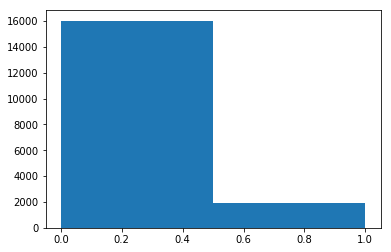

In [10]:
# Add plot
fig, ax = plt.subplots(1, 1)
# Add frequency plot
ax = plt.hist(ds_residues['LIP'], bins=2)

## Feature extraction

### Angles

In [11]:
# Define lists of angles phi and psi
phi, psi = list(), list()
# PePtideBuilder: build the peptides (reveal structure holes) and print sequences
ppb = PPBuilder()
# Loop thorugh every protein
for pdb_id in ds_original.pdb.unique():
    # Get structure of the protein
    structure = PDBParser(QUIET=True).get_structure(pdb_id, pdb_dir + '/pdb{}.ent'.format(pdb_id))
    # We select only the 0-th model
    model = structure[0]
    # Loop through every model's chain
    for chain in model:
        # Skip if the chain is not valid
        if (pdb_id, chain.id) not in valid_chains:
            continue
        # Loop through Peptides in the current chain
        for pp in ppb.build_peptides(chain):
            # Get phi and psi angles (rad)
            _phi, _psi = list(zip(*pp.get_phi_psi_list()))  # Separate psi, psi tuple
             # Concat angle lists
            phi += _phi
            psi += _psi

assert len(phi), len(ds_residues.shape[0])
assert len(psi), len(ds_residues.shape[0])

In [12]:
# Add PHI and PSI angles columns to residues dataset
ds_residues['PHI'] = pd.Series(phi)
ds_residues['PSI'] = pd.Series(psi)
ds_residues.head()

,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP,PHI,PSI
0,1cee,0,A,1,MET,0,0,NaN,1.703623
1,1cee,0,A,2,GLN,0,0,-1.593845,2.579637
2,1cee,0,A,3,THR,0,0,-2.488120,2.385817
3,1cee,0,A,4,ILE,0,0,-1.646228,2.694623
4,1cee,0,A,5,LYS,0,0,-1.963218,1.229750


In [13]:
ds_residues[ds_residues.PDB_ID == '1g3j'].head()

,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP,PHI,PSI
1066,1g3j,0,A,134,HIS,0,0,-1.180933,-0.705666
1067,1g3j,0,A,135,ALA,0,0,-1.046433,-0.778174
1068,1g3j,0,A,136,VAL,0,0,-1.157240,-0.847053
1069,1g3j,0,A,137,VAL,0,0,-1.076714,-0.631655
1070,1g3j,0,A,138,ASN,0,0,-1.134835,-0.611019


In [14]:
# Parse PHI and PSI from radiant to degree
ds_residues.PHI = ds_residues.PHI.apply(rad_to_deg,)
ds_residues.PSI = ds_residues.PSI.apply(rad_to_deg)
ds_residues.head()

,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP,PHI,PSI
0,1cee,0,A,1,MET,0,0,NaN,97.610436
1,1cee,0,A,2,GLN,0,0,-91.320582,147.802303
2,1cee,0,A,3,THR,0,0,-142.558762,136.697238
3,1cee,0,A,4,ILE,0,0,-94.321904,154.390554
4,1cee,0,A,5,LYS,0,0,-112.484101,70.459513


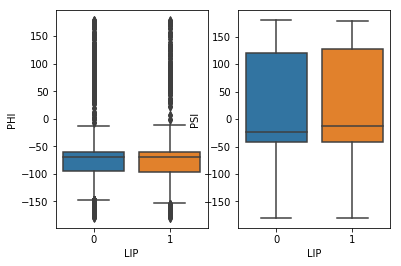

In [15]:
fig, ax = plt.subplots(1, 2)
sns.boxplot(x='LIP', y='PHI',data=ds_residues, ax=ax[0])
sns.boxplot(x='LIP', y='PSI',data=ds_residues, ax=ax[1])

### DSSP features

In [16]:
# Define a list of dssp features
dssp_list = list()

# Loop thorugh every protein
for pdb_id in ds_original.pdb.unique():
    # Parse structure of the protein
    structure = PDBParser(QUIET=True).get_structure(pdb_id, pdb_dir + '/pdb{}.ent'.format(pdb_id))
    # Get first model
    model = structure[0]
    # Define DSSP instance of the 0-th model
    dssp = DSSP(model, pdb_dir + '/pdb{}.ent'.format(pdb_id), dssp="/usr/local/bin/mkdssp")
    # Get DSSP features: dssp index, amino acid, secondary structure, relative ASA, phi, psi, NH_O_1_relidx, 
    # NH_O_1_energy, O_NH_1_relidx, O_NH_1_energy, NH_O_2_relidx, NH_O_2_energy, O_NH_2_relidx, O_NH_2_energy
    # Get chain id and residue id
    for ids, res in zip(dict(dssp), dssp):
        # Create the DSSP row
        row = list()
        row.append(pdb_id)
        row += list(ids) + list(res)
        # Add row to dssp list
        dssp_list.append(row)
        
# Define feature names
columns = ['PDB_ID', 'CHAIN_ID', 'RES_ID', 'DSSP_ID', 'AA', 'SEC_STRUCT', 'REL_ASA', 'PHI', 'PSI',
           'NH_O_1_relidx', 'NH_O_1_energy', 'O_NH_1_relidx', 'O_NH_1_energy', 'NH_O_2_relidx', 
           'H_O_2_energy', 'O_NH_2_relidx', 'O_NH_2_energy']

# Define DSSP DataFrame
ds_dssp = pd.DataFrame(dssp_list, columns=columns)
# Turn RES_ID from tuple to integer (gets 1-st element)
ds_dssp.RES_ID = ds_dssp.RES_ID.apply(lambda x: x[1])
# Show dataframe
ds_dssp.head()

,PDB_ID,CHAIN_ID,RES_ID,DSSP_ID,AA,SEC_STRUCT,REL_ASA,PHI,PSI,NH_O_1_relidx,NH_O_1_energy,O_NH_1_relidx,O_NH_1_energy,NH_O_2_relidx,H_O_2_energy,O_NH_2_relidx,O_NH_2_energy
0,1cee,A,1,1,M,-,1,360.0,97.6,0,0.0,2,-0.3,0,0.0,50,-0.1
1,1cee,A,2,2,Q,-,0.348485,-91.3,147.8,48,-0.1,50,-1.7,51,-0.0,2,-0.3
2,1cee,A,3,3,T,E,0.387324,-142.6,136.7,-2,-0.3,50,-0.2,48,-0.2,2,-0.2
3,1cee,A,4,4,I,E,0.00591716,-94.3,154.4,48,-1.9,50,-1.6,-2,-0.3,2,-0.6
4,1cee,A,5,5,K,E,0.346341,-112.5,70.5,-2,-0.2,71,-1.6,48,-0.1,2,-0.8


In [17]:
# Check NULL values in PHI and PSI columns
assert False == bool(ds_dssp.PHI.isnull().any())

In [18]:
# Drop useless features
ds_dssp.drop(['DSSP_ID', 'AA'], axis=1, inplace=True)
ds_dssp.head()

,PDB_ID,CHAIN_ID,RES_ID,SEC_STRUCT,REL_ASA,PHI,PSI,NH_O_1_relidx,NH_O_1_energy,O_NH_1_relidx,O_NH_1_energy,NH_O_2_relidx,H_O_2_energy,O_NH_2_relidx,O_NH_2_energy
0,1cee,A,1,-,1,360.0,97.6,0,0.0,2,-0.3,0,0.0,50,-0.1
1,1cee,A,2,-,0.348485,-91.3,147.8,48,-0.1,50,-1.7,51,-0.0,2,-0.3
2,1cee,A,3,E,0.387324,-142.6,136.7,-2,-0.3,50,-0.2,48,-0.2,2,-0.2
3,1cee,A,4,E,0.00591716,-94.3,154.4,48,-1.9,50,-1.6,-2,-0.3,2,-0.6
4,1cee,A,5,E,0.346341,-112.5,70.5,-2,-0.2,71,-1.6,48,-0.1,2,-0.8


In [19]:
# Drop useless columns from residues dataset
if 'PHI' in ds_residues.columns:
    ds_residues.drop(['PHI', 'PSI'], axis=1, inplace=True)
# Merge DSSP features in ds_residues dataset
ds_residues = ds_residues.merge(ds_dssp, on=['PDB_ID', 'CHAIN_ID', 'RES_ID'], how='left')
# Check new datset
ds_residues.head()

,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP,SEC_STRUCT,REL_ASA,PHI,PSI,NH_O_1_relidx,NH_O_1_energy,O_NH_1_relidx,O_NH_1_energy,NH_O_2_relidx,H_O_2_energy,O_NH_2_relidx,O_NH_2_energy
0,1cee,0,A,1,MET,0,0,-,1,360.0,97.6,0.0,0.0,2.0,-0.3,0.0,0.0,50.0,-0.1
1,1cee,0,A,2,GLN,0,0,-,0.348485,-91.3,147.8,48.0,-0.1,50.0,-1.7,51.0,-0.0,2.0,-0.3
2,1cee,0,A,3,THR,0,0,E,0.387324,-142.6,136.7,-2.0,-0.3,50.0,-0.2,48.0,-0.2,2.0,-0.2
3,1cee,0,A,4,ILE,0,0,E,0.00591716,-94.3,154.4,48.0,-1.9,50.0,-1.6,-2.0,-0.3,2.0,-0.6
4,1cee,0,A,5,LYS,0,0,E,0.346341,-112.5,70.5,-2.0,-0.2,71.0,-1.6,48.0,-0.1,2.0,-0.8


### RING features

In [58]:
# Define folder for ring files
ring_dir = './ring_files/'
ring_file = '{}.zip'.format(pdb_id)
# Define file which will contain contacts info
contact_dir = './contact_files/'
contact_file = "pdb{}.edges".format(pdb_id)

In [59]:
# Define POST request parameters to tell RING web service to start elaborating
req = {"pdbName": pdb_id, "chain": "all", "seqSeparation": "5", "networkPolicy": "closest", "nowater": "true", "ringmd": "false", "allEdges": "true",
       "thresholds": '{"hbond": 3.5, "vdw": 0.5, "ionic": 4, "pipi": 6.5, "pication": 5, "disulphide": 2.5}'}
# Define a request object to handle connection
r = requests.post('http://protein.bio.unipd.it/ringws/submit', data=json.dumps(req), headers={'content-type': 'application/json'})
# Define id of the job provided by RING
job_id = json.loads(r.text)['jobid']
# Print the id of the RING job
print(job_id)

5cf512b3b265bd294b0f6c90


In [60]:
# Check job status and wait until done
status = None
while status != 'complete':
    # Retrieve server elaboration status
    status = json.loads(requests.get('http://protein.bio.unipd.it/ringws/status/{}'.format(job_id)).text).get("status", None)
    # Show current status
    print(status)
    # Wait to avoid DDOS
    time.sleep(5)

db
db
db
db
db
db
complete


In [61]:
# Retrieve and save RING web service result
archive_file = "{}_network.zip".format(pdb_id)
r = requests.get("http://protein.bio.unipd.it/ring_download/{}/{}".format(job_id, archive_file))
with open(ring_dir + archive_file, "wb") as fout:
    fout.write(r.content)

In [63]:
# Extract the contact file from the archive
archive = zipfile.ZipFile(ring_dir + archive_file, 'r')
with open(contact_dir + contact_file, "wb") as fout:
    fout.write(archive.read("{}_edges.txt".format(pdb_id)))

In [66]:
tmp = pd.read_csv(contact_dir + 'pdb1cee.edges', sep='\t')
tmp.head()

,NodeId1,Interaction,NodeId2,Distance,Angle,Energy,Atom1,Atom2,Donor,Positive,Cation,Orientation
0,A:180:_:MG,IAC:LIG_MC,A:12:_:GLY,5.632,-999.9,0.0,MG,O,NaN,NaN,NaN,NaN
1,A:180:_:MG,IAC:LIG_MC,A:12:_:GLY,6.811,-999.9,0.0,MG,C,NaN,NaN,NaN,NaN
2,A:180:_:MG,IAC:LIG_SC,A:12:_:GLY,6.856,-999.9,0.0,MG,H,NaN,NaN,NaN,NaN
3,A:180:_:MG,IAC:LIG_SC,A:13:_:ALA,5.708,-999.9,0.0,MG,HA,NaN,NaN,NaN,NaN
4,A:180:_:MG,IAC:LIG_MC,A:13:_:ALA,6.784,-999.9,0.0,MG,CA,NaN,NaN,NaN,NaN


In [80]:
# Create chains with residue ids compatible with RING
nodes = {}
structure = PDBParser(QUIET=True).get_structure(pdb_id, pdb_dir + '/pdb{}.ent'.format(pdb_id))
for chain in structure[0]:
    nodes[chain.id] = []
    for residue in chain:
        if residue.id[0] == ' ':
            node = "{}:{}:{}:{}".format(chain.id, residue.id[1], residue.id[2] if residue.id[2] != ' ' else '_', residue.get_resname())
            nodes[chain.id].append(node)

In [83]:
nodes

{'A': ['A:1:_:MET',
  'A:2:_:GLN',
  'A:3:_:THR',
  'A:4:_:ILE',
  'A:5:_:LYS',
  'A:6:_:CYS',
  'A:7:_:VAL',
  'A:8:_:VAL',
  'A:9:_:VAL',
  'A:10:_:GLY',
  'A:11:_:ASP',
  'A:12:_:GLY',
  'A:13:_:ALA',
  'A:14:_:VAL',
  'A:15:_:GLY',
  'A:16:_:LYS',
  'A:17:_:THR',
  'A:18:_:CYS',
  'A:19:_:LEU',
  'A:20:_:LEU',
  'A:21:_:ILE',
  'A:22:_:SER',
  'A:23:_:TYR',
  'A:24:_:THR',
  'A:25:_:THR',
  'A:26:_:ASN',
  'A:27:_:LYS',
  'A:28:_:PHE',
  'A:29:_:PRO',
  'A:30:_:SER',
  'A:31:_:GLU',
  'A:32:_:TYR',
  'A:33:_:VAL',
  'A:34:_:PRO',
  'A:35:_:THR',
  'A:36:_:VAL',
  'A:37:_:PHE',
  'A:38:_:ASP',
  'A:39:_:ASN',
  'A:40:_:TYR',
  'A:41:_:ALA',
  'A:42:_:VAL',
  'A:43:_:THR',
  'A:44:_:VAL',
  'A:45:_:MET',
  'A:46:_:ILE',
  'A:47:_:GLY',
  'A:48:_:GLY',
  'A:49:_:GLU',
  'A:50:_:PRO',
  'A:51:_:TYR',
  'A:52:_:THR',
  'A:53:_:LEU',
  'A:54:_:GLY',
  'A:55:_:LEU',
  'A:56:_:PHE',
  'A:57:_:ASP',
  'A:58:_:THR',
  'A:59:_:ALA',
  'A:60:_:GLY',
  'A:61:_:GLN',
  'A:62:_:GLU',
  'A:63:_:AS

In [88]:
# Parse the edge file and generate the network
contact_threshold = 3.5
contacts = {}
# with open(out_contact_file) as f:
with open(contact_dir + contact_file) as f:
    next(f)
    for line in f:

        # node = chain:residue_number:insertion_code:residue_name
        # edge = localization:contact_type (localization MC = main chain, SC = side chain)
        node_1, edge, node_2, distance, _, _, atom_1, atom_2 = line.split()[0:8]

        distance = float(distance)
        if distance <= contact_threshold:
            # print line
            edge_type, edge_loc = edge.split(":")
            contacts.setdefault(node_1, [])
            contacts.setdefault(node_2, [])
            contacts[node_1].append((node_2, edge_loc, (atom_2, atom_1), edge_type))
            contacts[node_2].append((node_1, edge_loc, (atom_1, atom_2), edge_type))

# for chain in nodes:
#     for node in nodes[chain]:
#         print chain, node, contacts.get(node)

In [89]:
print(contacts)

{'A:180:_:MG': [('A:16:_:LYS', 'LIG_SC', ('HZ2', 'MG'), 'IAC'), ('A:17:_:THR', 'LIG_SC', ('HG1', 'MG'), 'IAC'), ('A:17:_:THR', 'LIG_SC', ('OG1', 'MG'), 'IAC'), ('A:35:_:THR', 'LIG_SC', ('OG1', 'MG'), 'IAC'), ('A:35:_:THR', 'LIG_SC', ('HG1', 'MG'), 'IAC'), ('A:35:_:THR', 'LIG_SC', ('HG21', 'MG'), 'IAC')], 'A:16:_:LYS': [('A:180:_:MG', 'LIG_SC', ('MG', 'HZ2'), 'IAC'), ('A:181:_:GCP', 'LIG_SC', ('O1G', 'HZ2'), 'IAC'), ('A:181:_:GCP', 'LIG_SC', ('O1B', 'HZ3'), 'IAC'), ('A:181:_:GCP', 'LIG_SC', ('O1G', 'HZ1'), 'IAC'), ('A:181:_:GCP', 'LIG_SC', ('O2B', 'HG2'), 'IAC'), ('A:181:_:GCP', 'LIG_SC', ('O1B', 'H'), 'IAC'), ('A:181:_:GCP', 'LIG_SC', ('O1G', 'HZ3'), 'IAC'), ('A:181:_:GCP', 'LIG_SC', ('O1G', 'NZ'), 'IAC'), ('A:181:_:GCP', 'LIG_SC', ('O2B', 'HZ3'), 'IAC'), ('A:181:_:GCP', 'LIG_SC', ('PB', 'HZ3'), 'IAC'), ('A:181:_:GCP', 'LIG_SC', ('O1B', 'HG2'), 'IAC'), ('A:181:_:GCP', 'LIG_SC', ('O2B', 'H'), 'IAC'), ('A:181:_:GCP', 'LIG_SC', ('PB', 'H'), 'IAC'), ('A:181:_:GCP', 'LIG_SC', ('PB', 'HG2'),

In [95]:
# *** Which are the residues with the highest ratio of inter/intra chain contacts?

top_nodes = []
for chain in nodes:
    features = []
    for node in nodes[chain]:
        inter = sum([1 for node2 in contacts.get(node, []) if node2[0][0] != chain])
        intra = sum([1 for node2 in contacts.get(node, []) if node2[0][0] == chain])

        features.append(float(inter) / (intra + 1))
    print(features)
    top_val = max(features)
    top_index = features.index(top_val)

    top_nodes.append(nodes[chain][top_index])

    print(chain, nodes[chain][top_index], top_val)
    print(len(features) == len(ds_residues[(ds_residues.PDB_ID == '1cee') & (ds_residues.CHAIN_ID == chain)].PDB_ID))

[0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0, 0.5, 1.0, 0.6666666666666666, 3.0, 0.25, 2.0, 0.6666666666666666, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 4.0, 0.0, 3.0]
A A:36:_:VAL 4.0
True
[0.0, 4.0, 1.0, 3.0, 